# Number of genes regulated by half sites
This modules looks at how many bound promoters are either bound by a motif, half sites, or another mode
We define a promoter regulated by half sites as one that has 10 or more half sites 

In [3]:
from KdtoEv2 import psfem
from KdtoEv2 import get_psfem
from KdtoEv2 import make_comparison_frame,add_psfem_info, getScores,get_tpr_fpr_lists, plotROCCurve, getSingleScore, getDoubleScore
from analyze_sig_hits_v2 import pssm, add_pwm_info,make_comparison_frame, get_pssm, get_max_pwm_score, one_weak_one_strong
from math import log,e
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import metrics
import os
import Bio
from Bio.Seq import Seq
from Bio.Alphabet.IUPAC import unambiguous_dna, ambiguous_dna
from Bio import SeqUtils


def removeCannon(df, cutoff = 13.01, tf = 'Gal4'):
	""" This function removes sequences with a canonical site based on the recommended PWM cutoff"""
	df["Score"] = df["Sequence"].apply(lambda x: get_max_pwm_score(x,tf))
	newdf = df[df["Score"]<cutoff]
	return newdf



def getSpacingMax200AndUp(inSeq, testSeq):
	""" This function count the the max number of half sites in a 200 bp window"""
	seq = Seq(str(inSeq), IUPAC.unambiguous_dna)
	totals = []
	for x in range(0,len(seq)-199):
		inputSeq = seq[x:x+200]
		totals.append(FindConsensusMotif(testSeq,inputSeq))
	if totals:
		return max(totals)
	else:
		return 0

    
    
def FindConsensusMotif(testseq,seq):
    
    ''' This function takes as input a "consensus motif", which is essentially a consensus sequence,
    but with Ns,Rs,Ys,Ks, and a sequence to scan. It will scan the sequence and return 
    a list of tuples that give the start and stop coordinates of all instances of the 
    consensus motif, on both strands of course.
    
    The consensusMotif variable can be passed to this function a string or a Seq object 
    The input_sequence variable can also be baseed as a string or Seq object'''

    input_sequence = Seq(str(seq),ambiguous_dna)
    consensusMotif = Seq(str(testseq),ambiguous_dna)
    
    #find all instances of consensus motif in forward strand of the sequence
    start_positions_forward = SeqUtils.nt_search(str(input_sequence), str(consensusMotif))[1:]
    
    #find all instances of consensus motif in the reverse strand of the sequence
    
    #first, take the reverse complement of the consensus motif
    rc_consensusMotif = consensusMotif.reverse_complement()
    
    if rc_consensusMotif == consensusMotif: #if consensusMotif is palindromic, don't search reverse strand
        end_positions_reverse = []
    else:
        end_positions_reverse = SeqUtils.nt_search(str(input_sequence), str(rc_consensusMotif))[1:]
    
    #output list of lists giving start and end positions of all motif 
    #instances.  For instance on the forward strand, start < end.  
    #For reverse strand, start > end.  The indices are zero indexed.
    output_list = []
    for startpos in start_positions_forward:
        position_list = [startpos,startpos+len(consensusMotif)-1]
        output_list.append(position_list)
    
    for endpos in end_positions_reverse:
        position_list = [endpos+len(consensusMotif)-1,endpos]
        output_list.append(position_list)
 
    
    return len(output_list)



In [1]:
def make_frame(sig_promoter_file, PWM_score, tf):
    """ This function makes a dataframe of bound promoters using a the recommended
        PWM cutoff 
    """
    cf = make_comparison_frame(sig_promoter_file,'sig_prom_Gal4_DBD_HarbIG_Final.txt',tf,'DBD')
    cf = add_pwm_info(cf, tf, PWM_score)
    bound_tf = cf[cf[tf+ " pvalue"]< 0.00001]
    bound_tf["Motif"]=bound_tf[tf+ " score"].apply(lambda x: 0 if x == [] else 1)
    return bound_tf 
#    return cf

def count_halfsites(bound_file):
    num = []
    seq= bound_file["Sequence"].tolist()
    for i in seq:
        num.append(getSpacingMax200AndUp(i, "CGG"))
    bound_file["halfsites"] = num
    return bound_file 

def make_type_bound_df(bound_tf, tf):
    """ This function makes a df of types of promoters
    """
    nosite_bound = bound_tf[bound_tf["Motif"] == 0]
    boundsite = bound_tf[bound_tf["Motif"] == 1]
    more_10 = nosite_bound[nosite_bound["halfsites"] >= 10]
    less_10 = nosite_bound[nosite_bound["halfsites"] < 10]
    n_site_bound= len(boundsite.index)
    n_less_10 = len(less_10.index) 
    n_more_10 = len(more_10.index)
#     total = [n_site_bound, n_less_10, n_more_10]
#     names = ["with_site", "CGG<10", "CGG>=10"]
    data = {"TF": tf, "with_site": n_site_bound, "CGG<10": n_less_10, "CGG>=10": n_more_10}
    output = pd.DataFrame(data, index = [tf])
    return output

def get_promoter_names(bound_tf):
    """ This function gets the names of promoters"""
    site = bound_tf[bound_tf["Motif"] == 1]
    s = site["Left Common Name"].tolist()
    nosite_bound = bound_tf[bound_tf["Motif"] == 0]
    more_10 = nosite_bound[nosite_bound["halfsites"] >= 10]
    less_10 = nosite_bound[nosite_bound["halfsites"] < 10]

    promoter = more_10["Left Common Name"].tolist()
    promoter_all = bound_tf["Left Common Name"].tolist()
    less = less_10["Left Common Name"].tolist()


    return s, promoter, less, promoter_all




In [5]:
replace_dict = {'chrI:':'chr1:',
                'chrII:':'chr2:',
                'chrIII:':'chr3:',
                'chrIV:': 'chr4:',
                'chrV:':'chr5:',
                'chrVI:':'chr6:',
                'chrVII:':'chr7:',
                'chrVIII:':'chr8:',
               'chrIX:':'chr9:',
                'chrX:':'chr10:',
                'chrXI:':'chr11:',
                'chrXII:':'chr12:',
                'chrXIII:':'chr13:',
                'chrXIV:':'chr14:',
                'chrXV:':'chr15:',
                'chrXVI:':'chr16:',
               'chrM:':'chr17:'}

replace_dict2 = {'chrI':'1',
                'chrII':'2',
                'chrIII':'3',
                'chrIV': '4',
                'chrV':'5',
                'chrVI':'6',
                'chrVII':'7',
                'chrVIII':'8',
               'chrIX':'9',
                'chrX':'10',
                'chrXI':'11',
                'chrXII':'12',
                'chrXIII':'13',
                'chrXIV':'14',
                'chrXV':'15',
                'chrXVI':'16',
               'chrM':'17'}

def change_chromosome_labels(sig_hits, tf):
    df = pd.read_csv(sig_hits, header=0, sep='\t')
    temp_column = df["Intergenic Region"]
    temp_column2 = df["Chr"]
    replace = []
    for i in temp_column2:
        chromosome_number = i
        #chromosome_number =i.split()
        #print(chromosome_number)
        replace.append(replace_dict2[chromosome_number])
    replace_column2 = pd.Series(replace)
    replace_array = []
    for x in temp_column:
        row = x.split()
        #print(row)
        replace_array.append(replace_dict[row[0]]+' '+row[1])
    replace_column = pd.Series(replace_array)
    df['Intergenic Region'] = replace_column
    df['Chr'] = replace_column2
    df.to_csv(tf + '_file_2.txt', header=True, index=False, sep='\t')
    

In [ ]:
change_chromosome_labels("sig_prom_ALL_GAL4_CSWAT_05232020_sorted2.ccf.txt", "gal4_cswat_all")
change_chromosome_labels("sig_prom_all_leu3_ccf_combined.ccf.txt", "leu3_all")
change_chromosome_labels("sig_prom_all_yrm1_ccf_combined.ccf.txt", "yrm1_all")
change_chromosome_labels("sig_prom_all_lys14_ccf_combined.ccf.txt", "lys14_all")
change_chromosome_labels("sig_prom_all_put3_ccf_combined.ccf.txt", "put3_all")
change_chromosome_labels("sig_prom_all_tea1_ccf_combined.ccf.txt", "tea1_all")
change_chromosome_labels("sig_prom_all_urc2_ccf_combined.ccf.txt", "urc2_all")
change_chromosome_labels("sig_prom_all_cat8_ccf_combined.ccf.txt", "cat8_all")
change_chromosome_labels("sig_prom_yrr1_ccf_out.ccf.txt", "yrr1_all")
change_chromosome_labels("sig_prom_all_aro80_ccf_combined.ccf.txt", "aro80_all")
change_chromosome_labels("sig_prom_all_cha4_ccf_combined.ccf.txt", "cha4_all")
change_chromosome_labels("sig_prom_all_hal9_ccf_combined.ccf.txt", "hal9_all")





In [6]:
bound_gal4 = make_frame("sig_prom_Gal4_FL_Final.txt", 13.01, "gal4")
bound_leu3 = make_frame("leu3_all_file_2.txt", 9.97, "leu3")
bound_yrm1 = make_frame("yrm1_all_file_2.txt", 13.41, "yrm1")
bound_yrr1 = make_frame("yrr1_all_file_2.txt", 13.12, "yrr1")
bound_tea1 = make_frame("tea1_all_file_2.txt", 14, "tea1")
bound_lys14 = make_frame("lys14_all_file_2.txt", 8, "lys14")
bound_cat8 = make_frame("cat8_all_file_2.txt", 7.31, "cat8")
bound_cha4 = make_frame("cha4_all_file_2.txt", 8.98, "cha4")
bound_put3 = make_frame("put3_all_file_2.txt", 12, "put3")
bound_urc2 = make_frame("urc2_all_file_2.txt", 13, "urc2")
bound_hal9 = make_frame("hal9_all_file_2.txt", 9, "hal9")
bound_aro80 = make_frame("aro80_all_file_2.txt", 11.42, "aro80")

/opt/apps/pybedtools/0.7.7/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/apps/jupyter/5.4.0-python2.7.12/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [11]:
bound_gal4

,gal4 TPH BS,gal4 pvalue,DBD TPH BS,DBD pvalue,Sequence,Log2FC,Left Common Name,Right Common Name,gal4 pos,gal4 score,gal4 orientaion,Motif
0,5223.260730,0.000000e+00,4726.492493,0.000000e+00,"(T, G, C, C, A, A, G, C, T, G, T, A, T, G, G, ...",-0.144181,EMP46,GAL2,[796],[16.12],[-1],1
1,4150.400945,0.000000e+00,3958.781375,0.000000e+00,"(C, A, T, A, C, A, A, T, G, G, A, G, C, T, G, ...",-0.068194,GAL7,GAL10,[327],[13.49],[1],1
2,3173.825349,0.000000e+00,3177.730496,0.000000e+00,"(C, G, C, C, G, C, T, A, G, A, A, C, T, G, G, ...",0.001774,SRP40,PTR2,[],[],[],0
3,2484.335559,0.000000e+00,1375.819691,0.000000e+00,"(T, T, A, T, G, C, C, T, A, A, A, G, A, T, T, ...",-0.852569,KTI12,HAP4,[],[],[],0
4,2469.753335,0.000000e+00,764.050697,0.000000e+00,"(T, A, C, A, T, C, G, A, A, G, A, G, A, T, T, ...",-1.692627,AGE1,SNA2,[],[],[],0
5,2506.170899,0.000000e+00,470.713154,0.000000e+00,"(A, A, T, C, A, T, A, A, G, T, T, G, A, A, T, ...",-2.412565,GAL10,GAL1,"[402, 404, 468]","[15.0, 13.69, 13.35]","[-1, 1, 1]",1
6,1877.685571,0.000000e+00,514.260217,0.000000e+00,"(C, T, A, T, C, A, A, A, T, G, G, T, G, A, A, ...",-1.868385,STP4,SIT4,[],[],[],0
7,1287.200611,0.000000e+00,443.015394,0.000000e+00,"(C, T, G, T, G, T, C, A, A, T, G, A, C, T, T, ...",-1.538808,TIM9,MMS21,[],[],[],0
8,989.894198,0.000000e+00,431.713628,0.000000e+00,"(T, C, A, T, T, C, C, A, A, T, G, A, A, T, A, ...",-1.197200,PCD1,ACS2,[],[],[],0
9,850.456623,0.000000e+00,362.676253,0.000000e+00,"(C, A, C, T, A, G, C, A, A, T, G, G, C, C, C, ...",-1.229555,CLN3,CYC3,[],[],[],0


In [7]:
bound_gal4 = count_halfsites(bound_gal4)
bound_leu3 = count_halfsites(bound_leu3)
bound_yrm1 = count_halfsites(bound_yrm1)
bound_yrr1 = count_halfsites(bound_yrr1)
bound_tea1 = count_halfsites(bound_tea1)
bound_lys14 = count_halfsites(bound_lys14)
bound_cat8 = count_halfsites(bound_cat8)
bound_cha4 = count_halfsites(bound_cha4)
bound_put3 = count_halfsites(bound_put3)
bound_urc2 = count_halfsites(bound_urc2)
bound_hal9 = count_halfsites(bound_hal9)
bound_aro80 = count_halfsites(bound_aro80)

In [8]:
gal4_out = make_type_bound_df(bound_gal4, "gal4")
leu3_out = make_type_bound_df(bound_leu3, "leu3")
lys14_out = make_type_bound_df(bound_lys14, "lys14")
put3_out = make_type_bound_df(bound_put3, "put3")
tea1_out = make_type_bound_df(bound_tea1, "tea1")
urc2_out = make_type_bound_df(bound_urc2, "urc2")
yrr1_out = make_type_bound_df(bound_yrr1, "yrr1")
cat8_out = make_type_bound_df(bound_cat8, "cat8")
yrm1_out = make_type_bound_df(bound_yrm1, "yrm1")
cha4_out = make_type_bound_df(bound_cha4, "cha4")
hal9_out = make_type_bound_df(bound_hal9, "hal9")
aro80_out = make_type_bound_df(bound_aro80, "aro80")

In [9]:
gal4_out

,CGG<10,CGG>=10,TF,with_site
gal4,22,49,gal4,11


In [11]:
tf_list = [bound_aro80, bound_cat8, bound_cha4, bound_gal4, bound_hal9, bound_leu3, bound_lys14, bound_put3, bound_tea1, bound_urc2, bound_yrm1, bound_yrr1]

In [12]:
d = []
e = []
f = []
g = []
for i in tf_list:
    a, b, c, z = get_promoter_names(i)
    d.append(a)
    e.append(b)
    f.append(c)
    g.append(z)
    

In [13]:
site_list = [item for sublist in d for item in sublist]
list10 = [item for sublist in e for item in sublist]
all_sites = [item for sublist in g for item in sublist]
less10 = [item for sublist in f for item in sublist]



sl = list(set(site_list))
list10 = list(set(list10)) 
total_sites = list(set(all_sites)) 
l10 = list(set(less10)) 





In [20]:
list_total = [len(total_sites), len(sl), len(list10), len(l10)]

In [21]:
names = ["Total targets", "With Canonical Site", "No site, CGG > 10", "No site, CGG < 10" ]

In [32]:
df = pd.DataFrame(list_poop, index = names, columns = ["Targets"])
df.to_csv("zinc_cluster_targets.csv", sep = "\t")

In [33]:
df

,Targets
Total targets,537
With Canonical Site,130
"No site, CGG > 10",146
"No site, CGG < 10",318


In [16]:
gal4_names = get_promoter_names(bound_gal4)
leu3_names = get_promoter_names(bound_leu3)
yrr1_names = get_promoter_names(bound_yrr1)
tea1_names = get_promoter_names(bound_tea1)
lys14_names = get_promoter_names(bound_lys14)
cat_names = get_promoter_names(bound_cat8)
put3_names = get_promoter_names(bound_put3)
urc2_names = get_promoter_names(bound_urc2)

yrm1_names = get_promoter_names(bound_yrm1)
aro80_names = get_promoter_names(bound_aro80)
hal9_names = get_promoter_names(bound_hal9)
cha4_names = get_promoter_names(bound_cha4)






name_list = gal4_names + leu3_names +yrr1_names+ tea1_names+ lys14_names + cat_names + put3_names + urc2_names + yrm1_names + aro80_names + cha4_names + hal9_names 
#n2 = gn2 + leun2 + yn2 + tn2 + lysn2 + cn2 + pn2+ un2
filtered_name_list = list(set(name_list))
#filtered_all  = list(set(n2))

In [10]:
len(filtered_name_list)

68

In [95]:
df_combined = [gal4_out, leu3_out, yrm1_out, yrr1_out, tea1_out, lys14_out, cat8_out, cha4_out, put3_out, urc2_out, hal9_out, aro80_out]

In [96]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,
                                            how='outer'), df_combined)

In [ ]:
pd.DataFrame.to_csv(df_merged, 'Robs_peakcaller_combined_bound_type_final.txt', sep='\t', na_rep='.', index=False)


In [97]:
df_merged

,CGG<10,CGG>=10,TF,with_site
0,22.0,49.0,gal4,11.0
1,34.0,42.0,leu3,32.0
2,63.0,49.0,yrm1,1.0
3,58.0,26.0,yrr1,0.0
4,70.0,47.0,tea1,0.0
5,28.0,6.0,lys14,15.0
6,11.0,6.0,cat8,40.0
7,19.0,7.0,cha4,2.0
8,15.0,6.0,put3,5.0
9,26.0,18.0,urc2,3.0


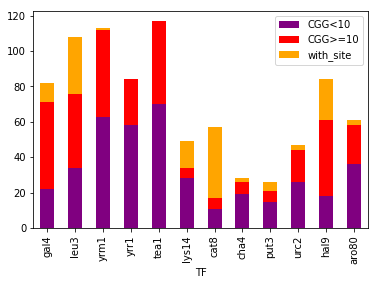

In [101]:
df_merged.set_index('TF').plot(kind='bar', stacked=True, colors = ["purple", "red", "orange"])
plt.savefig("num_genes_regulated_halfsites.pdf")